<a href="https://colab.research.google.com/github/buserken/thy_hisse/blob/main/thyao_hisse_tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gerekli Kütüphaneleri Yüklüyoruz

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Verisetini Yükleyip Veriyi İncelemeye Başlıyoruz

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MİN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving thyao.csv to thyao (7).csv


In [ ]:
df = pd.read_csv('thyao.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,3.613994,3.677398,3.487188,3.645696,3.585874,11846086
1,2010-01-05,3.645696,3.677398,3.613994,3.645696,3.585874,7929532
2,2010-01-06,3.645696,3.677398,3.550591,3.613994,3.554692,9721300
3,2010-01-07,3.550591,3.582293,3.518889,3.550591,3.492329,7407485
4,2010-01-08,3.550591,3.582293,3.487188,3.487188,3.429967,8583119


In [ ]:
def check_df(dataframe, head=5):
    print("------------- Shape -------------")
    print(dataframe.shape)
    print("------------- Types -------------")
    print(dataframe.dtypes)
    print("------------- Head -------------")
    print(dataframe.head(head))
    print("------------- Tail -------------")
    print(dataframe.tail(head))
    print("------------- Na -------------")
    print(dataframe.isnull().sum())
    print("------------- Quantiles -------------")


    numeric_df = dataframe.select_dtypes(include=['number'])
    print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

------------- Shape -------------
(2857, 7)
------------- Types -------------
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
------------- Head -------------
        Date      Open      High       Low     Close  Adj Close    Volume
0 2010-01-04  3.613994  3.677398  3.487188  3.645696   3.585874  11846086
1 2010-01-05  3.645696  3.677398  3.613994  3.645696   3.585874   7929532
2 2010-01-06  3.645696  3.677398  3.550591  3.613994   3.554692   9721300
3 2010-01-07  3.550591  3.582293  3.518889  3.550591   3.492329   7407485
4 2010-01-08  3.550591  3.582293  3.487188  3.487188   3.429967   8583119
------------- Tail -------------
           Date   Open   High    Low  Close  Adj Close     Volume
2852 2020-12-24  12.52  12.94  12.47  12.78      12.78  142896439
2853 2020-12-25  12.86  12.91  12.70  12.76      12.76   37913565
2854

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,3.613994,3.677398,3.487188,3.645696,3.585874,11846086
1,2010-01-05,3.645696,3.677398,3.613994,3.645696,3.585874,7929532
2,2010-01-06,3.645696,3.677398,3.550591,3.613994,3.554692,9721300
3,2010-01-07,3.550591,3.582293,3.518889,3.550591,3.492329,7407485
4,2010-01-08,3.550591,3.582293,3.487188,3.487188,3.429967,8583119


In [ ]:
thy_df = df[["Date","Close"]]
thy_df.head()

,Date,Close
0,2010-01-04,3.645696
1,2010-01-05,3.645696
2,2010-01-06,3.613994
3,2010-01-07,3.550591
4,2010-01-08,3.487188


In [ ]:
thy_df.index = thy_df["Date"]
thy_df.head()

,Date,Close
Date,,
2010-01-04,2010-01-04,3.645696
2010-01-05,2010-01-05,3.645696
2010-01-06,2010-01-06,3.613994
2010-01-07,2010-01-07,3.550591
2010-01-08,2010-01-08,3.487188


In [ ]:
thy_df.drop("Date", axis=1, inplace=True)
thy_df.head()

,Close
Date,
2010-01-04,3.645696
2010-01-05,3.645696
2010-01-06,3.613994
2010-01-07,3.550591
2010-01-08,3.487188


In [ ]:
result_df = thy_df.copy()

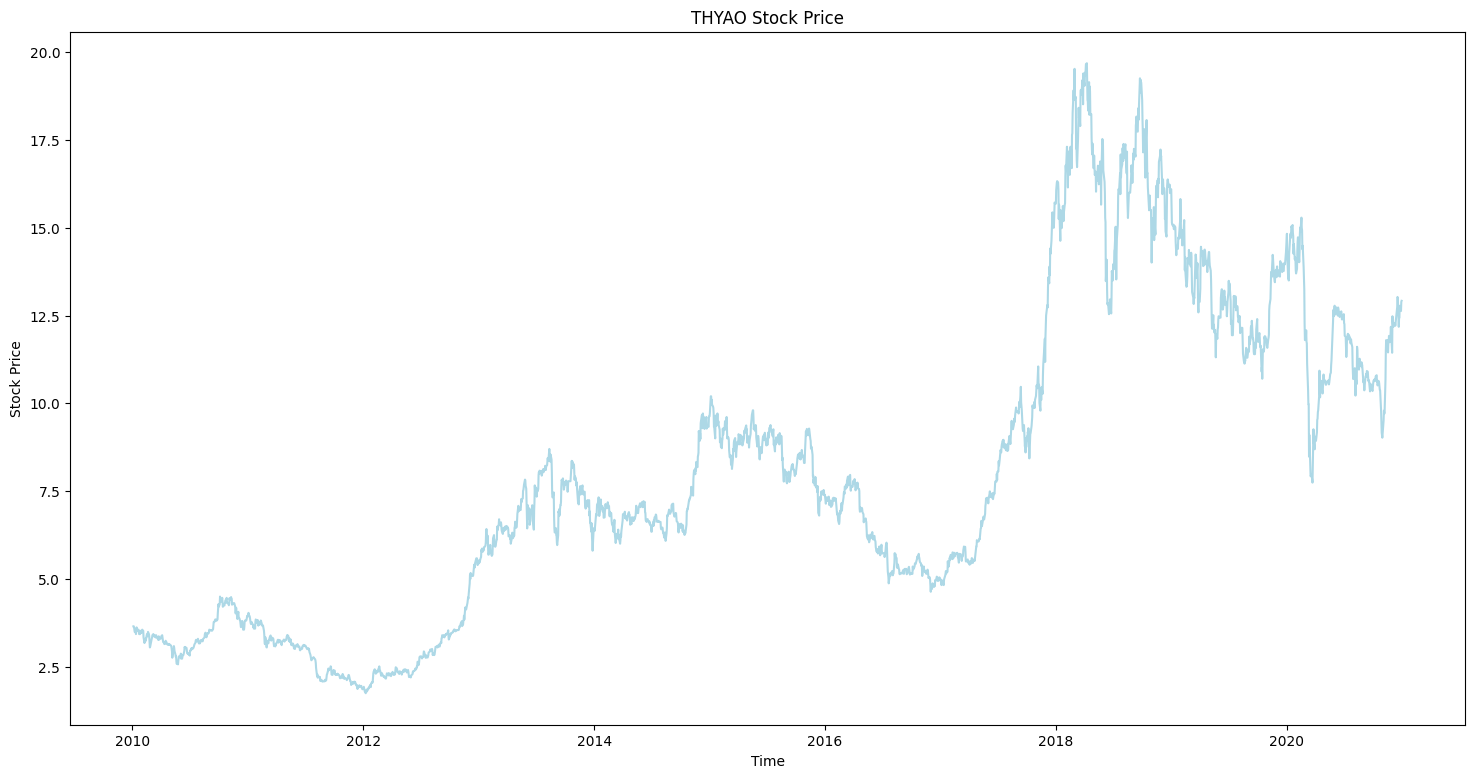

In [ ]:
#Görselleştirme
plt.figure(figsize=(18,9))
plt.plot(thy_df['Close'], color='lightblue')
plt.title('THYAO Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
# DataFrame'i NumPy dizisine dönüştürdüm.
thy_df = thy_df.values
thy_df

array([[ 3.645696],
       [ 3.645696],
       [ 3.613994],
       ...,
       [12.63    ],
       [12.89    ],
       [12.92    ]])

In [ ]:
thy_df = thy_df.astype('float32')
thy_df.dtype

dtype('float32')

In [ ]:
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train,test, pos

In [ ]:
#Yüzde 20 ve Üç Tane Ayırma İşlemi Yapıyorum
train,test, pos = split_data(thy_df, 0.20)

In [ ]:
print(train.shape, test.shape)

(2286, 1) (571, 1)


In [ ]:
# Train ve Test Veri Seti için dönüşümleri yapıyorum
scaler_train.fit(y_train)
train_predict = scaler_train.inverse_transform(train_predict)

NameError: name 'scaler_train' is not defined

In [ ]:
scaler_test.fit(y_test)
test_predict = scaler_test.inverse_transform(test_predict)

NameError: name 'scaler_test' is not defined

In [ ]:
train[0:5]

In [ ]:
test[0:5]

In [ ]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])

    return np.array(X), np.array(Y)

In [ ]:
lookback = 20 #lookback(lag) parametre değerimi 20 olarak belirliyorum
X_train, y_train = create_features(train, lookback)
X_test, y_test = create_features(test, lookback)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
print(X_train[0:5])
print(y_train[0:5])

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
model = Sequential()
model.add(LSTM(units=50,
               activation='relu',
               input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=2, mode='min'),
            ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                           save_best_only=True, save_weights_only=False, verbose=2)]

In [ ]:
history = model.fit(x=X_train,
                   y=y_train,
                   epochs=100,
                   batch_size=20,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks,
                   shuffle=False)

In [ ]:
#Grafiğini Çizdiriyorum
plt.figure(figsize=(16, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [ ]:
loss = model.evaluate(X_test, y_test, batch_size=20)
print("\nTest Loss : %1f%%" % (100.0 * loss))

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [ ]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
print(f"TRAİN RMSE : {train_rmse}")
print(f"TEST RMSE : {test_rmse}")

Hem train hem de test RMSE değerlerinin birbirine yakın olması, modelin iyi bir genel performans sergilediğini ve overfitting veya underfitting gibi problemlerin olmadığını gösterir.
Modelin Genel Performansı: RMSE değerlerinin bu kadar yakın olması, modelin hem eğitim verisinde hem de test verisinde benzer performans gösterdiğini ve bu da modelin genel anlamda iyi genelleme yaptığını gösterir.
Bu sonuçlar, modelin veri seti üzerinde dengeli bir şekilde çalıştığını ve tahminlerinin oldukça iyi olduğunu gösteriyor. RMSE değerleri düşük ve birbirine yakın olduğundan, modelin piyasadaki genel hareketleri iyi bir şekilde yakaladığını söyleyebiliriz. *italik metin* ***kalın metin***

In [ ]:
train_predict_df = result_df[lookback:pos]
train_predict_df["Predicted"] = train_predict
train_predict_df.head()

In [ ]:
train_predict_df = result_df.iloc[lookback:pos].copy()
train_predict_df["Predicted"] = train_predict

In [ ]:
#Gerçek ve Tahmin Edilen Değerleri Aynı Grafikte Göstererek Görselleştiriyorum
plt.figure(figsize=(20, 5))
plt.plot(train_predict_df.index, train_predict_df["Close"], label='Actual Values')
plt.plot(train_predict_df.index, train_predict_df["Predicted"], label='Predicted Values', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.title('Stock Analysis: Actual vs. Predicted Values', fontsize=16)
plt.show()